<a href="https://colab.research.google.com/github/AminaTkh/AlanTuringInstitute_Bias_in_AI/blob/main/Mitigating-Bias-and-Discrimination/Preprocessing_instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pre-processing technique: Reweighing for Statistical Parity**

Reweighing (Kamiran and Calders, 2012) is a pre-processing technique that amends the dataset to achieve statistical parity. The steps we will take are outlined below.

1. First, we will calculate Disparate Impact and Statistical Parity Difference metrics for our training dataset
2. Before we start using a predictive model, we will use the Reweighing technique on the full dataset just to explore how it works. This step should show that with the calculated weights assigned to the dataset, disparate impact and statistical parity difference are both removed.
3. We will then apply the Reweighing method to data used to train a predictive model and observe the results.

This notebook contains gaps in the code for you to fill in.

# Install Libraries and load data

In [1]:
# install holisticai
!pip install holisticai

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import RidgeClassifier

from holisticai.bias.mitigation import Reweighing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.4/241.4 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 8.1 MB/s eta 0:00:00


Load the data into a dataframe

In [2]:
# Load data
from sklearn.datasets import fetch_openml
bunch = fetch_openml(data_id=44270)
df = bunch['frame'].dropna()
df['Ethnicity_White'] = (df['Ethnicity'] == 'White')*1
df['Ethnicity_Black'] = (df['Ethnicity'] == 'Black')*1
df = df.drop(columns = ['Gender', 'Ethnicity'])
df


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
<ipython-input-2-64cb00eefb5b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ethnicity_White'] = (df['Ethnicity'] == 'White')*1
<ipython-input-2-64cb00eefb5b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,Label,0,1,2,3,4,5,6,7,8,...,42,43,44,45,46,47,48,49,Ethnicity_White,Ethnicity_Black
0,1,-0.178832,0.147077,0.775331,-0.427889,0.640818,-0.610427,-1.023371,1.431524,1.459619,...,-0.355889,-0.465837,-2.832634,0.917297,-0.241052,-2.122105,0.253170,0.164617,0,1
1,1,0.092276,0.122023,0.482935,-0.232131,-1.939064,-1.140216,-0.833250,-1.281904,0.228971,...,-1.417751,1.254152,0.631731,1.665469,-0.388293,-0.804782,-0.227182,0.412375,0,0
2,0,-1.703377,-0.962149,-0.785495,-0.633902,-0.334718,-1.555958,0.825006,0.274443,1.448419,...,0.079523,-0.932425,-0.693293,-0.114197,-1.252067,0.834270,-0.463270,0.559294,0,0
4,1,-0.363013,1.264307,1.667603,0.903941,-0.062840,0.680886,0.389930,-0.000803,-0.782676,...,-0.311236,2.447118,1.127650,0.086733,-0.381553,0.209684,0.197809,-0.879914,0,0
5,0,0.152488,-0.731821,-0.167126,-1.193398,1.180502,0.469656,-0.044317,-0.409883,0.625990,...,-0.298833,2.067846,0.304233,-0.160228,1.017770,-1.002570,0.844326,-1.155311,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0,-1.706395,-0.435942,0.645464,-0.859816,0.914893,-0.022199,-0.424393,-0.976591,0.672857,...,0.181203,0.367494,0.162101,-1.688369,-1.151553,0.777658,-1.044357,-0.074341,0,0
9995,1,-0.057075,1.791513,-1.065756,-0.783341,-0.559215,1.042646,-1.154058,1.094753,1.968674,...,0.021583,1.718576,1.171804,0.430075,3.340726,1.349216,1.481516,0.070563,0,0
9996,1,0.582066,0.086788,0.167259,-1.672798,1.537135,-1.113315,0.222907,-1.743083,-0.086986,...,-0.072920,-1.841719,-0.807065,-0.793955,-1.098300,-1.474154,-0.828826,-0.891166,0,1
9997,0,-1.355098,-0.321228,-0.204290,0.498632,1.634130,0.847070,-0.552140,-1.614727,2.337347,...,-1.781911,0.275032,0.690859,0.666878,0.644440,0.127891,1.277781,-0.744428,1,0


In [3]:
prot_cols = ['Ethnicity_White', 'Ethnicity_Black']
prot_cols

['Ethnicity_White', 'Ethnicity_Black']

## Calculate unwanted historic bias in our training data

Using holisticai library, compute Disparate Impact and Statistical Parity Difference. Display a table showing the two metrics, alongside their target value (1 for Disparate Impact, 0 for Statistical Parity Difference)

Use the holisticai documentation : https://holisticai.readthedocs.io/en/latest/metrics.html#binary-classificationhttps://holisticai.readthedocs.io/en/latest/metrics.html#binary-classification


Set up variables for the privileged and unprivileged groups. In this example we will assign 'White' as our privileged group and 'Black' as unpriviledged.

In [4]:
# Compute Disparate Impact and Statistical Parity Difference metrics for the original dataset, without Reweighing
from holisticai.bias import metrics as bias_metrics

# Set up variables for the privileged and unprivileged groups

group_a = df.Ethnicity_Black == 1
group_b = df.Ethnicity_White == 1
y = df.Label


# Compute fairness metrics on the original dataset without Reweighing

fairness_metrics = pd.DataFrame(index = ['Disparate Impact', 'Statistical Parity'], columns = ['Value', 'Target value'])
fairness_metrics.loc['Disparate Impact'] = [bias_metrics.disparate_impact(group_a, group_b, y), 1]
fairness_metrics.loc['Statistical Parity'] = [bias_metrics.statistical_parity(group_a, group_b, y), 0]

fairness_metrics


,Value,Target value
Disparate Impact,0.887131,1
Statistical Parity,-0.044949,0


# Apply Reweighing to the full dataset
Now, use the [Reweighing](https://holisticai.readthedocs.io/en/latest/generated/holisticai.bias.mitigation.Reweighing.html#holisticai.bias.mitigation.Reweighing) technique to assign weights to each training data tuple.

In [5]:
X_ = df.drop(columns=["Label"])
y_ = df.Label

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

group_a = X_.Ethnicity_Black == 1
group_b = X_.Ethnicity_White == 1

In [13]:
# instantiate
rew = Reweighing()

# Use Reweighing to assign weights to each training data tuple
rew.fit(y_train, group_a, group_b)

# Display the sample weights
rew.estimator_params['sample_weight']


array([1.0126162, 1.0047332, 0.9923013, ..., 0.9881544, 1.0047332,
       0.9881544], dtype=float32)

# Run a baseline predictive model without applying reweighing
Now, we will build a standard Ridge Classifier and observe some baseline results, using the original data without Reweighing.

Train a Ridge Classifier with 10 fold stratified cross validation. Compute performance metrics (Accuracy, Precision, Recall and F1 Score) and fairness metrics (Average Odds Difference, Equal Opportunity Difference, Disparate Impact, Statistical Parity Difference)

In [14]:
# Instantiate the classifier

model = RidgeClassifier(random_state=42)

# instantiate the cross-validation scheme
mv = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

# setup the performance metrics to be computed
perf_metrics = {"Accuracy": metrics.accuracy_score,
                "Precision": metrics.precision_score,
                "Recall": metrics.recall_score,
                "F1-Score": metrics.f1_score,
                }

In [15]:
# Train a ridge regression classifier on the dataset before reweighing (this code is ready to run, there are no gaps to fill)
k, i = True, 1

# instantiating X
X = df.drop(columns=["Label"])

# instantiating the target variable
y = df['Label']

for (train, test) in mv.split(X, y):
    # inst model
    model = RidgeClassifier(random_state=10)

    # instantiating X
    X_train = X.iloc[train].copy()

    # instantiating y
    y_train = y.iloc[train].copy()

    # fit model NOT including sample weights calculated in reweighing
    model.fit(X_train, y_train)

    # X_test
    X_test = X.iloc[test]

    # set up vectors
    group_a = X_test.Ethnicity_Black == 1
    group_b = X_test.Ethnicity_White == 1
    y_pred = model.predict(X_test)
    y_true = y.iloc[test].values.ravel()
    params = [group_a, group_b, y_pred]

    # compute performance metrics
    metric_list = []
    for pf in perf_metrics.keys():
            metric_list += [[pf, perf_metrics[pf](y_true, y_pred)]]

    # Compute fairness metrics
    metric_list += [['Statistical Parity Difference', bias_metrics.statistical_parity(group_a, group_b, y_pred)]]
    metric_list += [['Disparate Impact', bias_metrics.disparate_impact(group_a, group_b, y_pred)]]
    metric_list += [['Equalized Odds Difference', bias_metrics.average_odds_diff(group_a, group_b, y_pred,y_true)]]
    metric_list += [['False Negative Rate Difference', bias_metrics.false_negative_rate_diff(group_a, group_b, y_pred,y_true)]]

    # concatenate results
    df_m = pd.DataFrame(metric_list, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics_orig = df_m.copy()
        k=0
    else:
        df_metrics_orig = pd.concat([df_metrics_orig, df_m.copy()], axis=0, ignore_index=True)

df_metrics_orig

,Metric,Value,Fold
0,Accuracy,0.718358,1
1,Precision,0.648936,1
2,Recall,0.552870,1
3,F1-Score,0.597064,1
4,Statistical Parity Difference,-0.027914,1
...,...,...,...
75,F1-Score,0.569024,10
76,Statistical Parity Difference,-0.074951,10
77,Disparate Impact,0.773810,10
78,Equalized Odds Difference,-0.033967,10


In [16]:
# Display metrics

metrics_table_orig = df_metrics_orig.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
metrics_table_orig


,mean,std
,Value,Value
Metric,,
Accuracy,0.705317,0.016053
Disparate Impact,0.773345,0.148610
Equalized Odds Difference,-0.076834,0.066988
F1-Score,0.576514,0.023378
False Negative Rate Difference,0.108095,0.097671
Precision,0.629599,0.025415
Recall,0.531917,0.024603
Statistical Parity Difference,-0.085088,0.060566


# Use Reweighing algorithm to train a predictive model

Amend your Ridge Classifier routine above to apply Reweighing to each fold of training data. Do not apply Reweighing at test time. Compute performance metrics (Accuracy, Precision, Recall and F1 Score) and fairness metrics (Average Odds Difference, Equal Opportunity Difference, Disparate Impact, Statistical Parity Difference)

In [17]:
# Instantiate the classifier

model = RidgeClassifier()

# instantiate the cross-validation scheme
mv = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

# setup the performance metrics to be computed
perf_metrics = {"Accuracy": metrics.accuracy_score,
                "Precision": metrics.precision_score,
                "Recall": metrics.recall_score,
                "F1-Score": metrics.f1_score,
                }


In [18]:
# Train a ridge regression classifier on the dataset before reweighing (this code is ready to run, there are no gaps to fill)
k, i = True, 1

# instantiating X
X = df.drop(columns=["Label"])

# instantiating the target variable
y = df.Label


for (train, test) in mv.split(X, y):
    model = RidgeClassifier()

    # instantiating X
    X_train = X.iloc[train].copy()

    # instantiating y
    y_train = y.iloc[train].copy()

    # set up vectors
    group_a = X_train.Ethnicity_Black == 1
    group_b = X_train.Ethnicity_White == 1

    # compute Reweighing sample weights

    rw = Reweighing()
    rw.fit(y_train, group_a, group_b)
    sample_weight = rw.estimator_params['sample_weight']

    # fit model including sample weights calculated in reweighing

    model.fit(X_train, y_train, sample_weight=sample_weight)

    # X_test
    X_test = X.iloc[test]

    # set up vectors
    group_a = X_test.Ethnicity_Black == 1
    group_b = X_test.Ethnicity_White == 1
    y_pred = model.predict(X_test)
    y_true = y.iloc[test].values.ravel()
    params = [group_a, group_b, y_pred]

    # compute performance metrics
    metric_list = []
    for pf in perf_metrics.keys():
            metric_list += [[pf, perf_metrics[pf](y_true, y_pred)]]

    # Compute fairness metrics
    metric_list += [['Statistical Parity Difference', bias_metrics.statistical_parity(*params)]]
    metric_list += [['Disparate Impact', bias_metrics.disparate_impact(*params)]]
    metric_list += [['Equalized Odds Difference', bias_metrics.average_odds_diff(*params,y_true)]]
    metric_list += [['False Negative Rate Difference', bias_metrics.false_negative_rate_diff(*params,y_true)]]

    # concatenate results
    df_m = pd.DataFrame(metric_list, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics_rw = df_m.copy()
        k=0
    else:
        df_metrics_rw = pd.concat([df_metrics_rw, df_m.copy()], axis=0, ignore_index=True)

In [19]:
# Display metrics

metrics_table_rw = df_metrics_rw.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
metrics_table_rw

,mean,std
,Value,Value
Metric,,
Accuracy,0.708284,0.011696
Disparate Impact,0.935024,0.153614
Equalized Odds Difference,-0.014241,0.058328
F1-Score,0.581285,0.018518
False Negative Rate Difference,0.035425,0.084557
Precision,0.633717,0.017714
Recall,0.537057,0.021523
Statistical Parity Difference,-0.025179,0.055481


# Present results to show the effectiveness of the Reweighing method

Present graphs (bar charts work well) to show how each performance and fairness metric differs for the baseline model compared with the application of Reweighing.

In [51]:
# Present graphs to show each performance and fairness metrics

table = pd.concat([metrics_table_orig, metrics_table_rw], axis=1).iloc[:,[0,2]]
table.columns = ['Baseline', 'Reweighting']
table

,Baseline,Reweighting
Metric,,
Accuracy,0.705317,0.708284
Disparate Impact,0.773345,0.935024
Equalized Odds Difference,-0.076834,-0.014241
F1-Score,0.576514,0.581285
False Negative Rate Difference,0.108095,0.035425
Precision,0.629599,0.633717
Recall,0.531917,0.537057
Statistical Parity Difference,-0.085088,-0.025179


In [79]:
table1 = table.drop(columns=['Reweighting']).copy()
table1 = table1.rename(columns= {'Baseline':'Value'})
table1['Method'] = 'Original'
table2 = table.drop(columns=['Baseline']).copy()
table2 = table2.rename(columns= {'Reweighting':'Value'})
table2['Method'] = 'Reweighting'


In [80]:
table_res = pd.concat([table1, table2], axis = 0)

In [81]:
table_res

,Value,Method
Metric,,
Accuracy,0.705317,Original
Disparate Impact,0.773345,Original
Equalized Odds Difference,-0.076834,Original
F1-Score,0.576514,Original
False Negative Rate Difference,0.108095,Original
Precision,0.629599,Original
Recall,0.531917,Original
Statistical Parity Difference,-0.085088,Original
Accuracy,0.708284,Reweighting


<Axes: xlabel='Metric', ylabel='Value'>

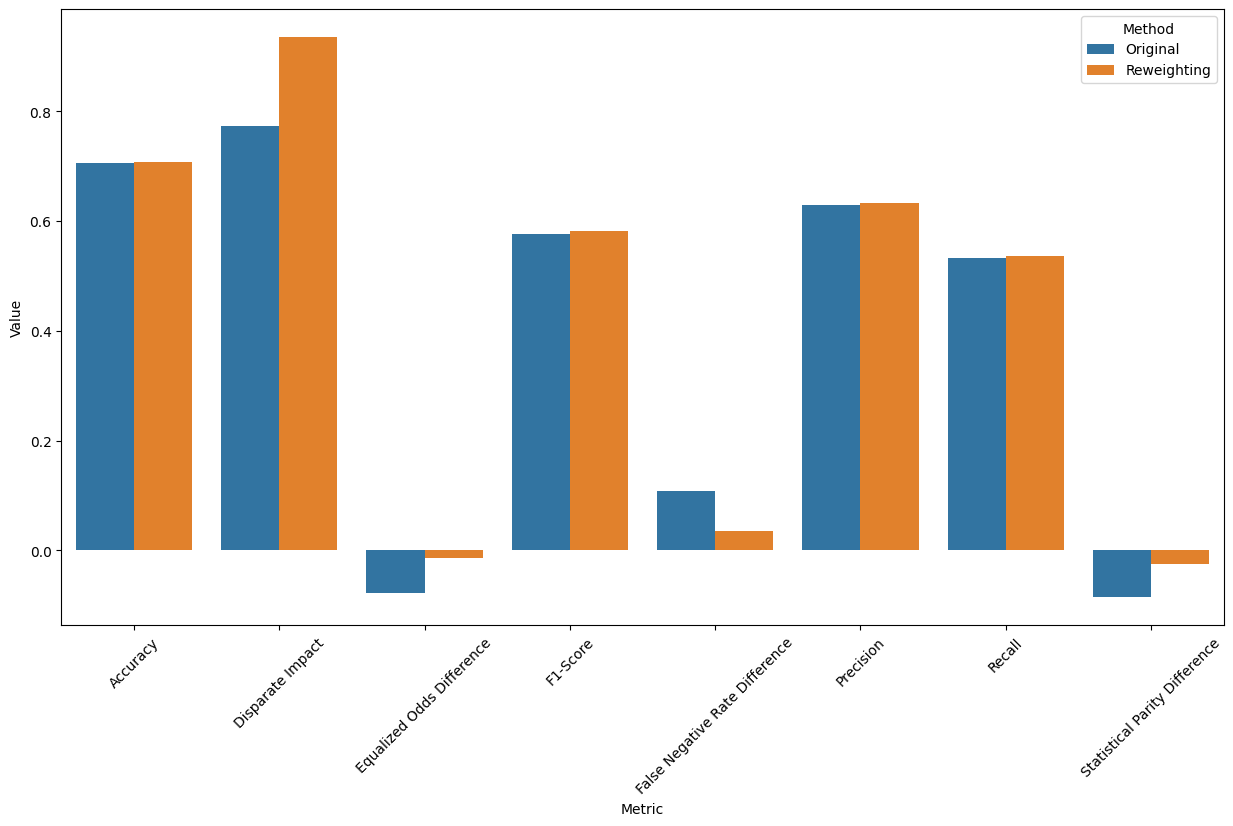

In [90]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.barplot(data=table_res, x=table_res.index, y="Value", hue='Method')
